In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
import random
import os

Using TensorFlow backend.


In [2]:
# Load the directories
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Train_dir = "Dataset/Train"
Test_dir = "Dataset/test1"

Train_size = len([name for name in os.listdir(Train_dir)])
Test_size = len([name for name in os.listdir(Test_dir)])
print("Number of training images:", Train_size)
print("Number of test images:", Test_size)

Files in 'C:\\Users\\solai\\Desktop\\Dogs_VS_Cats': ['.git', '.ipynb_checkpoints', 'Dataset', 'mobilenetv2_1.h5', 'mobilenetv2_2.h5', 'models.py', 'models_no_BN.py', 'Prediction.ipynb', 'Saved_Models', 'submission.csv', 'Training.ipynb', 'Transfer_Learning.ipynb', '__pycache__']
Number of training images: 25000
Number of test images: 12462


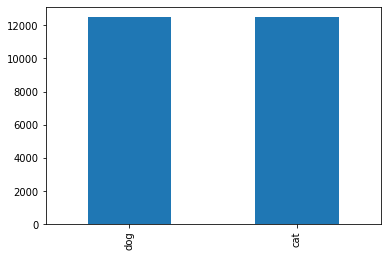

In [3]:
# Prepare the data

# Creating df with training files

filenames = os.listdir(Train_dir)
labels = []

for filename in filenames:
    label = filename.split('.')[0]
    labels.append(label)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : labels
})

# Total count of the categories
df['category'].value_counts().plot.bar()

In [4]:
# Splitting the data into train & validation

Batch_size = 16
split_size = 0.2
Image_width = 224
Image_height = 224
Image_size = (Image_width, Image_height)
Input_shape = (Image_width, Image_height, 3 )
train_df, valid_df = train_test_split(df,test_size = split_size)

In [5]:
# Training Generator 

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    Train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = Image_size,
                                                    batch_size = Batch_size,
                                                    class_mode = 'binary'
                                                    )

for image_data, lables in train_generator:
    print('image shape:', image_data.shape)
    print('lables batch shape;', lables.shape)
    break
    
train_generator.class_indices

Found 20000 validated image filenames belonging to 2 classes.
image shape: (16, 224, 224, 3)
lables batch shape; (16,)


{'cat': 0, 'dog': 1}

In [6]:
# Validation Generator

valid_datagen = ImageDataGenerator(rescale = 1/255)

valid_generator = train_datagen.flow_from_dataframe(valid_df,
                                                    Train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = Image_size,
                                                    batch_size = Batch_size,
                                                    class_mode = 'binary'
                                                    )


Found 5000 validated image filenames belonging to 2 classes.


In [7]:
# Prepare Testing Dataset


test_filenames = os.listdir(Test_dir)    
    
test_df = pd.DataFrame({
    'filename' : test_filenames   
})

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  Test_dir,
                                                  x_col = 'filename',
                                                  y_col = None,
                                                  class_mode = None,
                                                  target_size = Image_size,
                                                  batch_size = 32,
                                                  shuffle = False )


Found 12462 validated image filenames.


### Transfer Learning

The base model is created from the MobileNetV2 model developed by Google. This was pretrained on ImageNet dataset.


In [8]:
# Create the base model from the pre-trained model MobileNet V2

base_model = tf.keras.applications.MobileNetV2(input_shape=Input_shape,
                                               include_top=False,
                                               weights='imagenet')

W0607 16:16:47.204219 10032 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
feature_batch = base_model(image_data)
print(feature_batch.shape)

(16, 7, 7, 1280)


### Feature Extraction

Freeze the Convolutional base from previous step. Added a classifier on top of it and trained the top level classifier

In [10]:
#base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Build Model

In [11]:
for layer in base_model.layers[:100]:
    layer.trainable = False

for layer in base_model.layers[100:]:
    layer.trainable = True

last_layer = base_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, x) 


W0607 16:16:53.606219 10032 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


last layer output shape:  (None, 7, 7, 1280)


### Compile the model

In [12]:
Lr = 0.0001 
epochs = 10
model.compile(optimizer = RMSprop(lr=Lr),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()

W0607 16:16:53.671213 10032 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

block_12_project_BN (BatchNorma (None, 14, 14, 96)   384         block_12_project[0][0]           
__________________________________________________________________________________________________
block_12_add (Add)              (None, 14, 14, 96)   0           block_11_add[0][0]               
                                                                 block_12_project_BN[0][0]        
__________________________________________________________________________________________________
block_13_expand (Conv2D)        (None, 14, 14, 576)  55296       block_12_add[0][0]               
__________________________________________________________________________________________________
block_13_expand_BN (BatchNormal (None, 14, 14, 576)  2304        block_13_expand[0][0]            
__________________________________________________________________________________________________
block_13_expand_relu (ReLU)     (None, 14, 14, 576)  0           block_13_expand_BN[0][0]         
__________

### Fit Model

In [13]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = valid_generator,
                              steps_per_epoch = train_df.shape[0]//Batch_size,
                              validation_steps = valid_df.shape[0]//Batch_size,
                              verbose = 2)


Epoch 1/10
1250/1250 - 336s - loss: 0.1385 - acc: 0.9453 - val_loss: 0.6224 - val_acc: 0.9179
Epoch 2/10
1250/1250 - 242s - loss: 0.0902 - acc: 0.9675 - val_loss: 0.4829 - val_acc: 0.9425
Epoch 3/10
1250/1250 - 228s - loss: 0.0771 - acc: 0.9720 - val_loss: 0.2945 - val_acc: 0.9631
Epoch 4/10
1250/1250 - 225s - loss: 0.0669 - acc: 0.9761 - val_loss: 0.1129 - val_acc: 0.9683
Epoch 5/10
1250/1250 - 222s - loss: 0.0579 - acc: 0.9800 - val_loss: 0.2661 - val_acc: 0.9577
Epoch 6/10
1250/1250 - 231s - loss: 0.0542 - acc: 0.9819 - val_loss: 0.1411 - val_acc: 0.9730
Epoch 7/10
1250/1250 - 226s - loss: 0.0528 - acc: 0.9829 - val_loss: 0.4035 - val_acc: 0.9201
Epoch 8/10
1250/1250 - 227s - loss: 0.0470 - acc: 0.9842 - val_loss: 0.2457 - val_acc: 0.9571
Epoch 9/10
1250/1250 - 232s - loss: 0.0443 - acc: 0.9852 - val_loss: 0.1888 - val_acc: 0.9633
Epoch 10/10
1250/1250 - 223s - loss: 0.0384 - acc: 0.9877 - val_loss: 0.1704 - val_acc: 0.9724


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


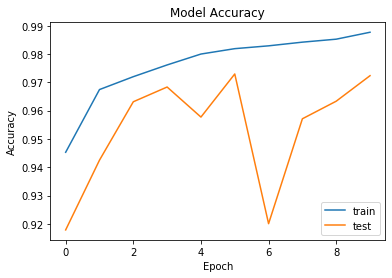

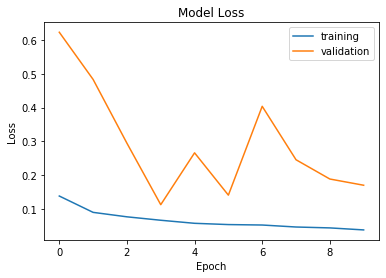

In [14]:
# Plot the accuracy and loss curves

print(history.history.keys())

# Results on Training and Validation Set

training_acc  = history.history['acc']
training_loss = history.history['loss']

validation_acc  = history.history['val_acc']
validation_loss = history.history['val_loss']

epochs = range(len(training_acc))

# Plot Training and Validation Accuracy

plt.plot(epochs,training_acc)
plt.plot(epochs,validation_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc = 'lower right')
plt.figure()

# Plot Training and Validation Loss 

plt.plot(epochs,training_loss)
plt.plot(epochs,validation_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training','validation'], loc = 'upper right')
plt.show()

In [15]:
model.save('Saved_Models/Dogs_VS_Cats_model_TF_01.h5')
model.save_weights("mobilenetv2_1.h5")

In [16]:
loss,accuracy = model.evaluate(valid_generator, steps = valid_df.shape[0]//Batch_size)

312/312 [==============================] - 44s 140ms/step - loss: 0.1938 - acc: 0.9673


In [17]:
predict = model.predict_generator(test_generator, steps=np.ceil(Test_size/32))

predict = [1 if y > 0.5 else 0 for y in predict]

# Category 1 = dog, 0 = cat
 
test_df['category'] = predict
test_df[15:20]

,filename,category
15,10045.jpg,1
16,10046.jpg,1
17,10047.jpg,1
18,10048.jpg,1
19,10049.jpg,0


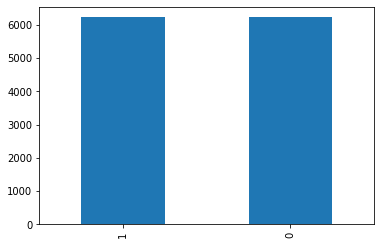

In [18]:
test_df['category'].value_counts().plot.bar()

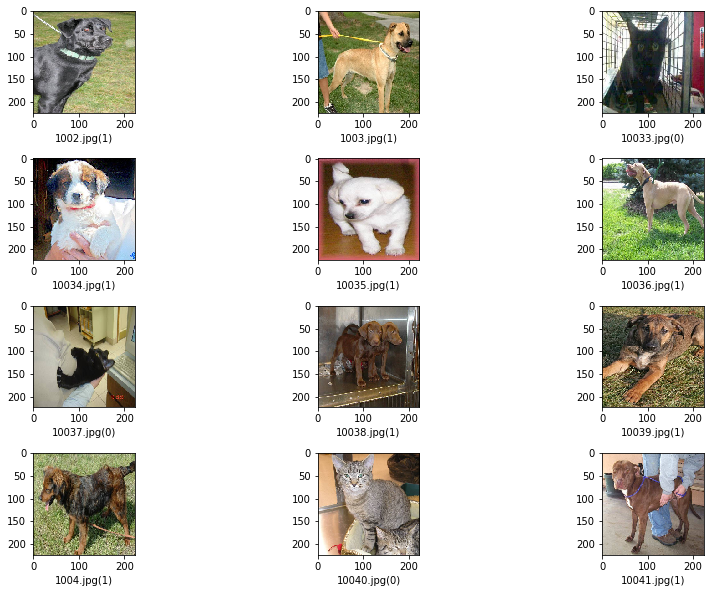

In [19]:
# Visualise the predictions

sample_test = test_df.head(12)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = tf.keras.preprocessing.image.load_img("Dataset/test1/"+filename, target_size=Image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()